# Machine Learning in Finance - Models Training

This notebook will focus on *how well we can forecast closing stocks using machine learning methods*.

*Authors:* [Mina Attia](https://people.epfl.ch/mina.attia), [Arnaud Felber](https://people.epfl.ch/arnaud.felber), [Rami Atassi](https://people.epfl.ch/rami.atassi) & [Paulo Ribeiro](https://people.epfl.ch/paulo.ribeirodecarvalho)

## Import

Import all python scripts and/or libraries needed.

In [1]:
import warnings

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
from sklearn.model_selection import train_test_split
from models.linear_regression import OLS, OLSLasso, OLSElasticNet, OLSRidge
from models.pearson_correlation import PearsonCorrelation
from models.random_forest import RandomForest

# Suppress UserWarning about feature names
warnings.filterwarnings(action='ignore', category=UserWarning, message='X has feature names')

%load_ext autoreload
%autoreload 2

## Data

We load the data processed with no `NaN` values. Please note that each predictor also are standardize for coherence between them.

In [2]:
# Initiate the data path and label to optimize
file_path = 'data/data_imputed.csv'
label = 'return'
seed = 42

# Load the data
data = pd.read_csv(filepath_or_buffer=file_path)
data['date'] = pd.to_datetime(data['date'])  # Ensure the date column is in datetime format
data = data.sort_values('date')  # Sort the data by date
date_column = data['date'].reset_index(drop=True)  # Save the date column for later
X = data.drop(columns=['permno', 'date', 'return', 'log_return', 'price', 'log_price'])
y = data[label]

# Standardize data
scaler = MinMaxScaler()  # Note in import step, you can choose other standardization method.  MinMaxScaler > StandardScaler. QuantileTransformer very good for standard OLS
X = pd.DataFrame(scaler.fit_transform(X=X), columns=X.columns)  # Standardize the predictors
X = pd.concat([date_column, X], axis=1)  # Add back the date column
# Split in train and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, shuffle=False)

# Display description of 'date' column for train and test set before removing it
print("Description of 'date' column for train set:")
print(X_train['date'].describe())
print("\nDescription of 'date' column for test set:")
print(X_test['date'].describe())
 
# Remove the date column
X_train = X_train.drop(columns='date')
X_test = X_test.drop(columns='date')

Description of 'date' column for train set:
count                          1396218
mean     1997-03-30 16:52:14.295646720
min                1980-01-01 00:00:00
25%                1990-05-01 00:00:00
50%                1997-09-01 00:00:00
75%                2004-05-01 00:00:00
max                2011-12-01 00:00:00
Name: date, dtype: object

Description of 'date' column for test set:
count                           349055
mean     2016-04-26 03:22:22.856570112
min                2011-12-01 00:00:00
25%                2014-02-01 00:00:00
50%                2016-04-01 00:00:00
75%                2018-08-01 00:00:00
max                2020-11-01 00:00:00
Name: date, dtype: object


## Methods

Describe which method we will train and test.

### Person Correlation Matrix

This allows to see which predictors are highly correlated. If two predictors are highly correlated we might don't want to keep both then we delete the least correlated with our label (return).

,pair,correlation
0,"(EBM, BPEBM)",0.999808
1,"(AM, Leverage)",0.986174
2,"(IdioVol3F, RealizedVol)",0.982106
3,"(zerotrade, zerotradeAlt12)",0.973945
4,"(HerfAsset, Herf)",0.945221
5,"(dNoa, NOA)",0.944448
6,"(zerotradeAlt1, zerotrade)",0.942450
7,"(InvestPPEInv, dNoa)",0.923709
8,"(DolVol, Size)",0.922138
9,"(dNoa, AssetGrowth)",0.918073


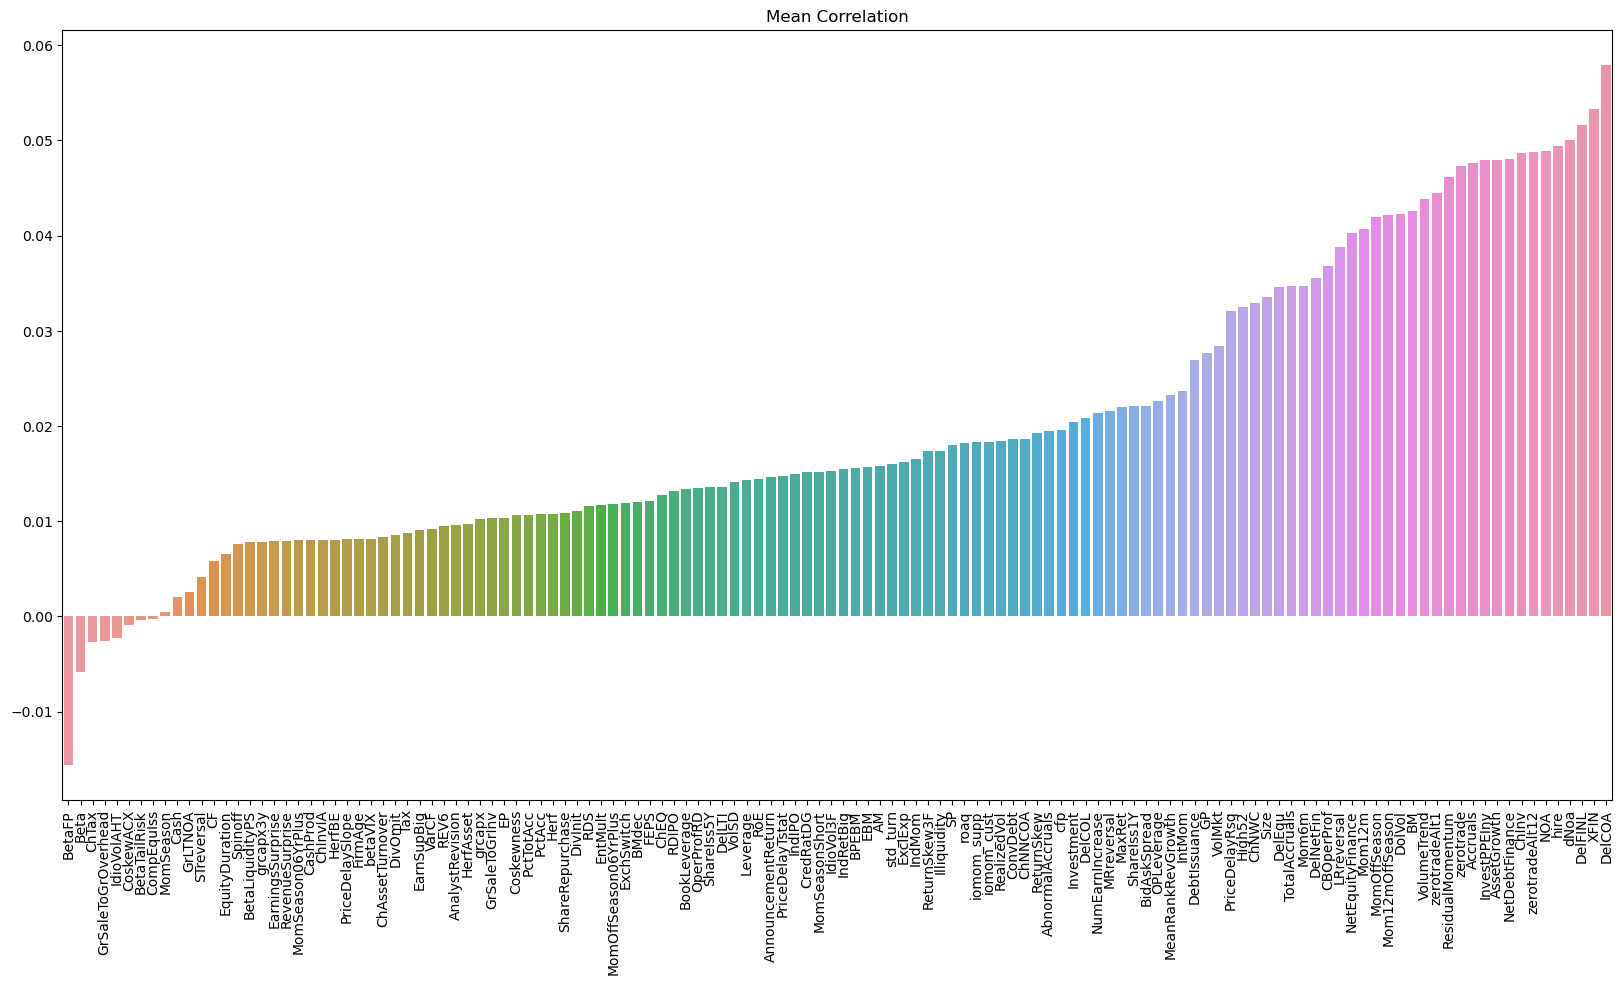

In [8]:
# Compute the correlation between predictors
correlation = PearsonCorrelation(data=X)  # Takes ~1-2min to run

# Display the top 10 most absolute correlated
highest_pairs_abs_correlation = correlation.get_sorted_abs_correlation_pairs(ascending=False, top_k_pairs=10)
display(highest_pairs_abs_correlation)

# Finally, plot the median correlation between a predictors and the others
correlation.plot(
    plot_type='mean'
)  # plot_type can be 'mean' or 'median' (or 'heatmap' but it is not recommended for large datasets)

It is interesting that Beta is inversely correlated with the other predictors, which accentuates the importance of the other predictors compared to a traditional market prediction.

### OLS

One basic idea is to compute the linear regression of our predictors in function of our label and to see the weights given to each predictor. As seen in class, using regularization can help achieve predictors selection. We then implement :

1) Simple OLS
2) Lasso OLS
3) Elastic Net


#### Simple OLS

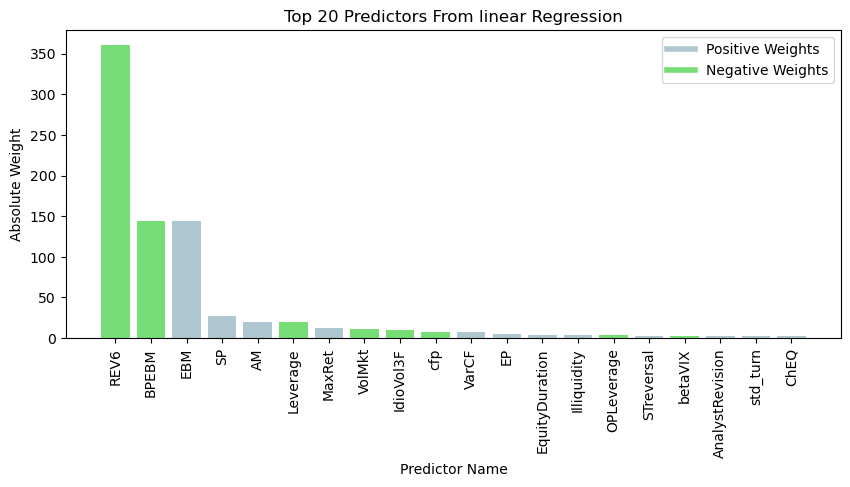

Training R-Square of the Simple OLS: 0.016


In [4]:
# Initiate Simple OLS model
ols_model = OLS(predictors=X_train,
                label=y_train)

# Train the model, show OLS selected weights and training R_square
ols_model.fit()
ols_model.show_weights()
print(f'Training R-Square of the Simple OLS: {ols_model.r_square:.3f}')

#### Lasso OLS

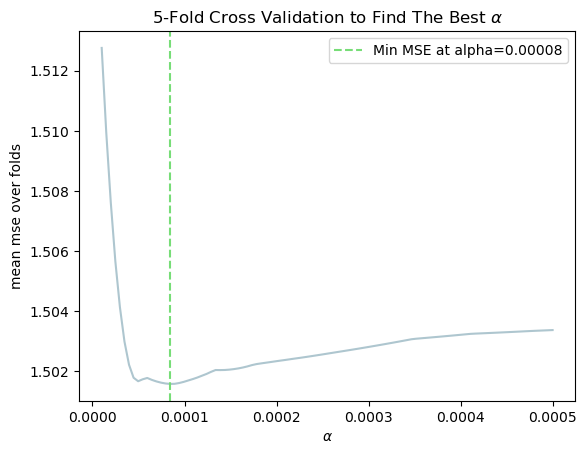

In [5]:
# Initiate Lasso model
ols_lasso_model = OLSLasso(predictors=X_train,
                           label=y_train,
                           alpha=None)  # Note, that alpha set to None will produce a CV step to found the optimal alpha

# Train the model
ols_lasso_model.fit()

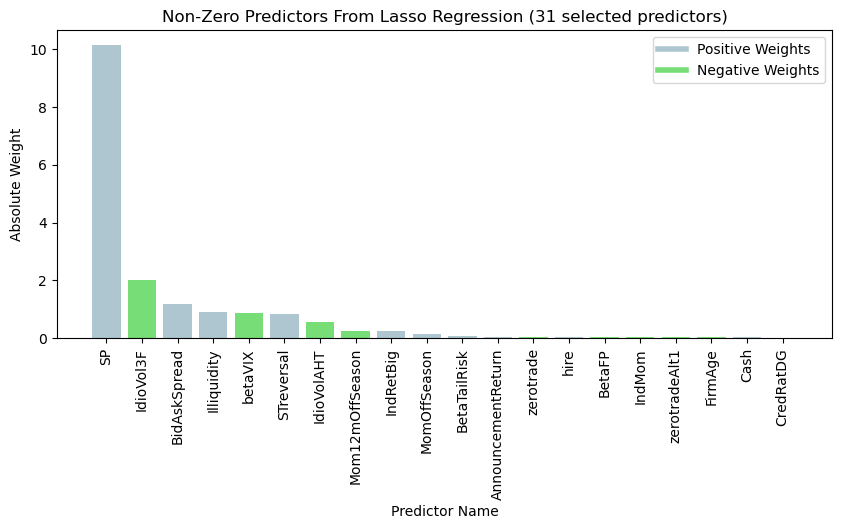

Training R-Square of the Lasso OLS: 0.004


In [6]:
# Once alpha have been properly set, show Lasso selected weights and training R_square
ols_lasso_model.show_weights()
print(f'Training R-Square of the Lasso OLS: {ols_lasso_model.r_square:.3f}')

#### Ridge OLS

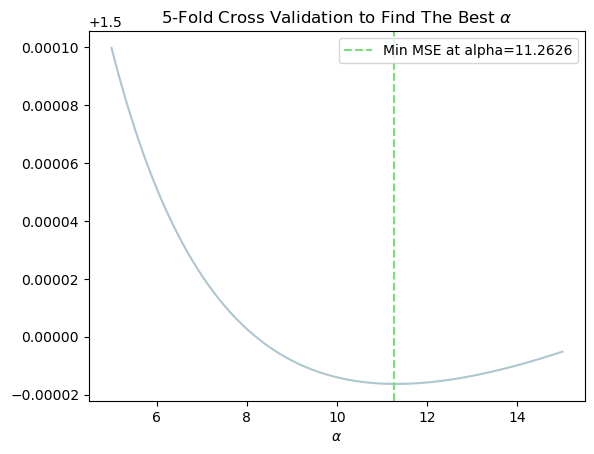

In [7]:
# Initiate Ridge model
ols_ridge_model = OLSRidge(predictors=X_train,
                            label=y_train,
                            alpha=None)  # Note, that alpha set to None will produce a CV step to found the optimal alpha

# Train the model
ols_ridge_model.fit()

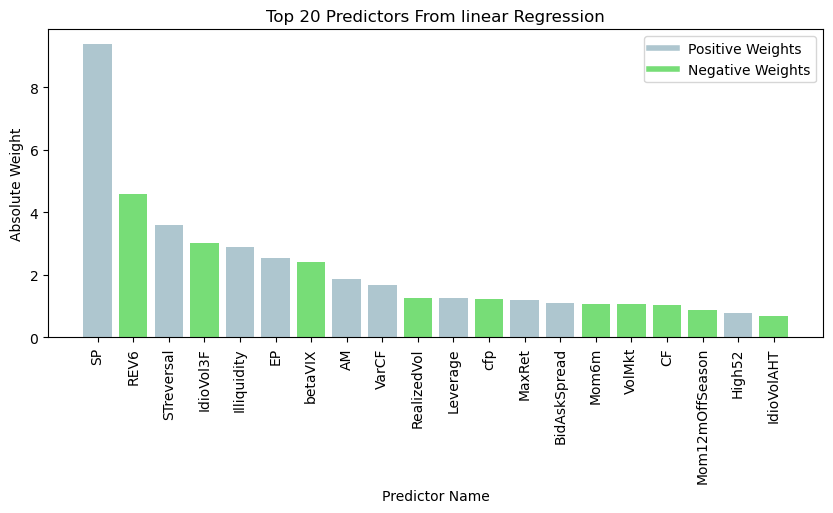

Training R-Square of the Ridge OLS: 0.006


In [8]:
# Once alpha have been properly set, show Ridge selected weights and training R_square
ols_ridge_model.show_weights()
print(f'Training R-Square of the Ridge OLS: {ols_ridge_model.r_square:.3f}')

#### Elastic Net

alpha: 8e-06 l1_ratio: 1e-05


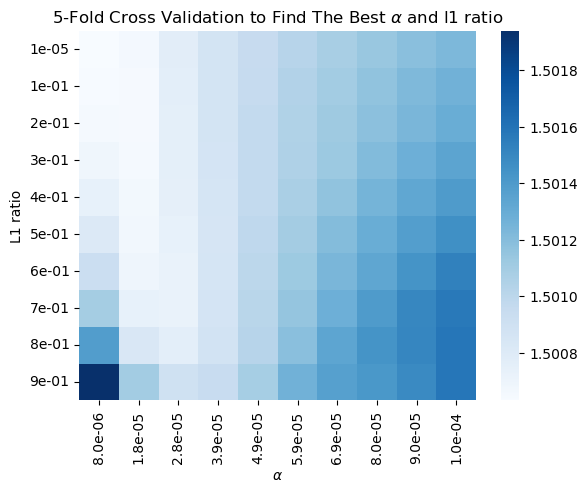

In [3]:
# Initiate ElasticNet model
ols_elastic_model = OLSElasticNet(predictors=X_train,
                                  label=y_train,
                                  alpha=None,  # Note, that alpha set to None will produce a CV step to found the optimal alpha
                                  l1_ratio=None)  # Same as alpha for l1_ratio

# Train the model
ols_elastic_model.fit()

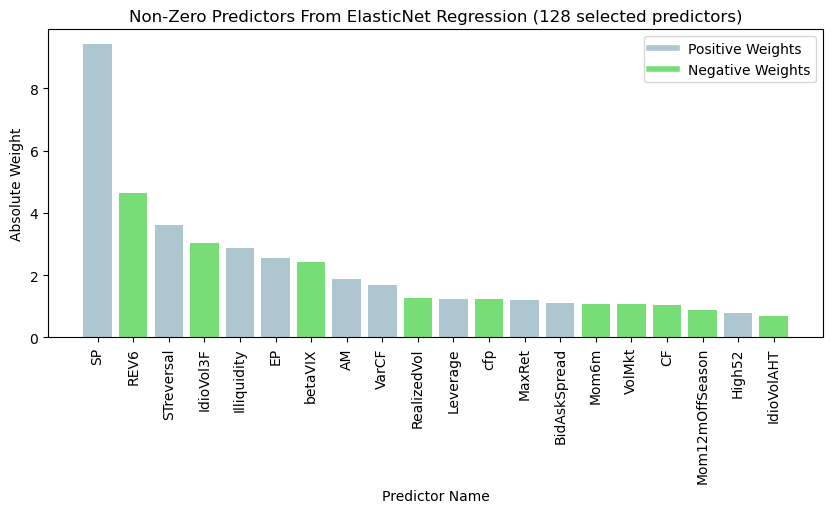

Training R-Square of the Elastic Net OLS: 0.006


In [4]:
# Once alpha have been properly set, show Lasso selected weights and training R_square
ols_elastic_model.show_weights()
print(f'Training R-Square of the Elastic Net OLS: {ols_elastic_model.r_square:.3f}')

### Random Forest

Using Random Forest can also be a good way to select predictors. We then train a Random Forest into our label using the whole Dataset and we look at the importance of each predictors.

In [12]:
# test_data = data.sample(300000)
rf = RandomForest(predictors = X_train, label = y_train)

In [13]:
best_results = rf.hyperparameter_tuning_with_crossvalidation(max_features=['sqrt', 'log2'], n_estimators=[50, 100], max_depth=[3],
                                              cv_splits=3)

print('The best hyperparameters are: ', best_results)

  param_n_estimators param_max_depth param_max_features  mean_test_score
0                100               3               log2        -0.072196
1                100               3               sqrt        -0.084353
2                 50               3               log2        -0.122927
3                 50               3               sqrt        -0.130564
The best hyperparameters are:  {'max_depth': 3, 'max_features': 'log2', 'n_estimators': 100}


In [14]:
rf.set_model(n_estimators=100, max_depth=3, max_features='log2')
rf.fit_predict_and_print_score()

With the following data:
- Data shape: (1396218, 128)
and the following hyperparameters:
- n_estimators: 100
- max_depth: 3
- max_features: log2
The R2 score is: 0.3122002806428773


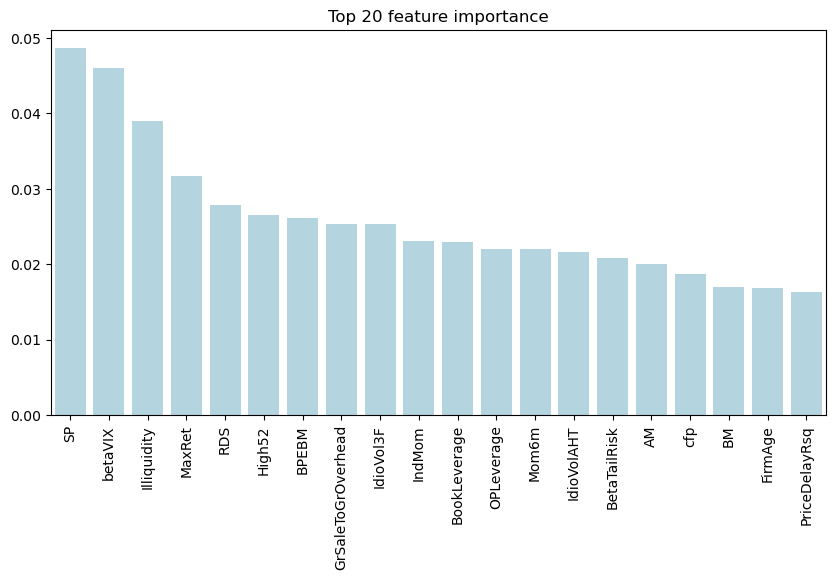

In [15]:
rf.plot_feature_importance()

## Results

We will test our models and compare them to see which one outperform the others.

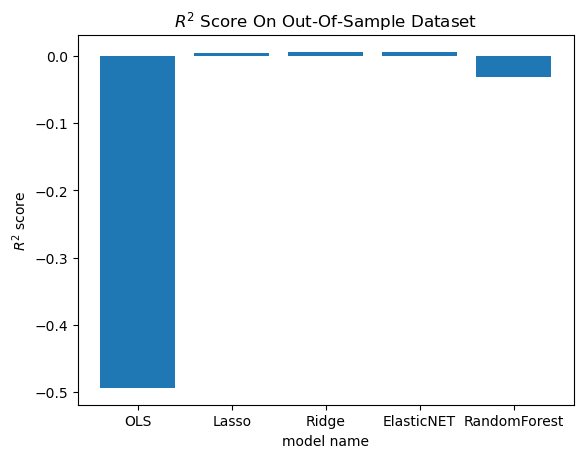

Test R-Square of the Simple OLS: -49.421%
Test R-Square of the Lasso OLS: 0.455%
Test R-Square of the Ridge OLS: 0.650%
Test R-Square of the ElasticNet OLS: 0.650%
Test R-Square of the Random Forest: -3.149%
To be continued...


In [20]:
# Compute all test R_square for each method here
test_score_ols = ols_model.reg.score(X_test, y_test)
test_score_lasso = ols_lasso_model.reg.score(X_test, y_test)
test_score_ridge = ols_ridge_model.reg.score(X_test, y_test)
test_score_elastic = ols_elastic_model.reg.score(X_test, y_test)
test_score_rf = rf.model.score(X_test, y_test)
...

# TODO: We could make this evaluation with k-fold and plot some boxplot with the mean r_square and its variance. Just an idea.
model_names = ['OLS', 'Lasso', 'Ridge', 'ElasticNET', 'RandomForest']
test_scores = [test_score_ols, test_score_lasso, test_score_ridge, test_score_elastic, test_score_rf]  #TODO: Set to zero for the moment

# Display the results
plt.bar(model_names, test_scores)
plt.title(r'$R^2$ Score On Out-Of-Sample Dataset')
plt.xlabel('model name')
plt.ylabel(r'$R^2$ score')

plt.show()

print(f'Test R-Square of the Simple OLS: {test_score_ols * 100:.3f}%\n'
      f'Test R-Square of the Lasso OLS: {test_score_lasso * 100:.3f}%\n'
      f'Test R-Square of the Ridge OLS: {test_score_ridge * 100:.3f}%\n'
      f'Test R-Square of the ElasticNet OLS: {test_score_elastic * 100:.3f}%\n'
        f'Test R-Square of the Random Forest: {test_score_rf * 100:.3f}%\n'
      f'To be continued...')